# OpenAI Codex Beta Testing 

## I - Extract Bitcoin time series data from an API

In [4]:
"""
Read dataframe using Pandas from here : "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv")
print(df.shape)
df.head()

(3201, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


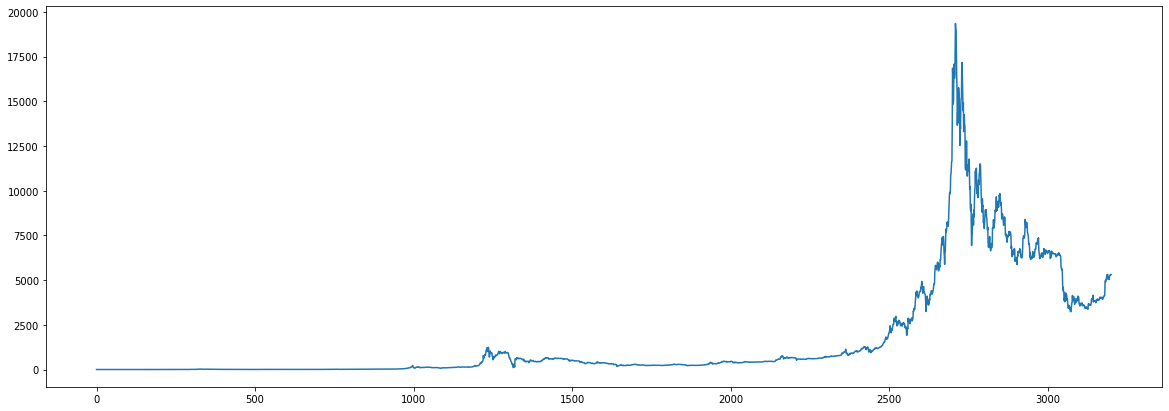

In [5]:
"""
Plot the column Close of dataframe using matplotlib
"""
def plot_close(df):
    plt.figure(figsize=(20,7))
    plt.plot(df['Close'])
    plt.show()

plot_close(df)

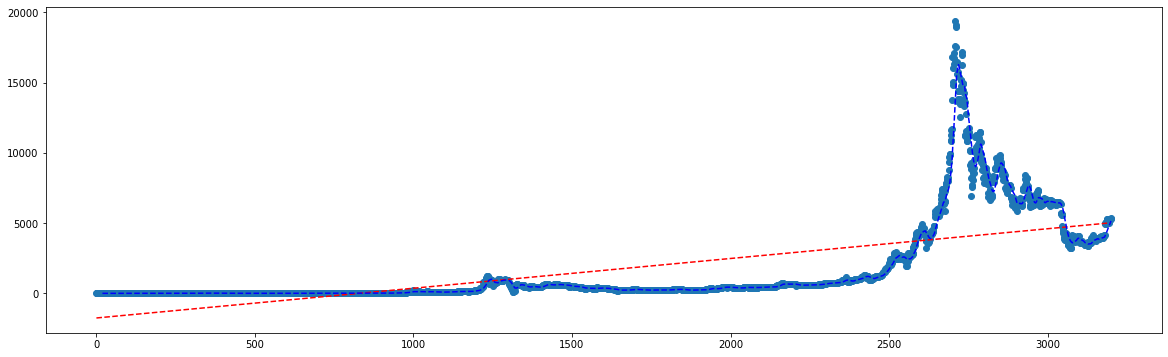

In [6]:
"""
Plot the column Close of df dataframe using matplotlib
"""
def plot_close_scatter_with_trendline_and_rolling_mean(df):

    plt.figure(figsize=(20,6)) # this line is not written by an AI :)

    plt.scatter(df.index, df['Close'])
    z = np.polyfit(df.index, df['Close'], 1)
    p = np.poly1d(z)
    plt.plot(df.index,p(df.index),"r--")
    plt.plot(df.index, df['Close'].rolling(window=20).mean(), "b--")
    plt.show()

plot_close_scatter_with_trendline_and_rolling_mean(df)

In [9]:
"""
Extract column Close from a dataframe df and convert it to a numpy list and reshape it
"""
def get_close_data(df):
    close_data = df['Close'].values
    close_data = close_data[~np.isnan(close_data)] # this line is not written by an AI :)
    close_data = close_data.reshape(-1,1)
    return close_data

close_price = get_close_data(df)
close_price.shape

(3201, 1)

## II - Translate raw data into train/val/test datasets

In [10]:
"""
Use Minmaxscaler to normalize data using sklearn
"""
from sklearn.preprocessing import MinMaxScaler
# My code
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_price)

In [11]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

## III - Deep Learning training

In [13]:
"""
Create a Bidirectional LSTM model with Dropout using Keras 
"""

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

def create_model(input_shape, output_shape):
    """
    Create a Bidirectional LSTM model with Dropout using Keras 
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(output_shape, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [14]:
input_shape =  [SEQ_LEN, 1]
output_shape = 1
model = create_model(input_shape, output_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 128)          33792     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
42/42 [==============================] - 1s 22ms/step - loss: 2.5992e-04 - accuracy: 3.7736e-04 - val_loss: 0.0102 - val_accuracy: 0.0000e+00
Epoch 2/50
42/42 [==============================] - 1s 19ms/step - loss: 2.6243e-04 - accuracy: 3.7736e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 3/50
42/42 [==============================] - 1s 19ms/step - loss: 2.1092e-04 - accuracy: 3.7736e-04 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 4/50
42/42 [==============================] - 1s 19ms/step - loss: 2.0389e-04 - accuracy: 3.7736e-04 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 5/50
42/42 [==============================] - 1s 19ms/step - loss: 2.0933e-04 - accuracy: 3.7736e-04 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 6/50
42/42 [==============================] - 1s 19ms/step - loss: 2.2438e-04 - accuracy: 3.7736e-04 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 7/50
42/42 [==============================] - 1s 19ms/step - loss: 1.7736e-0

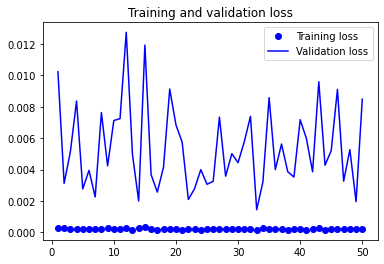

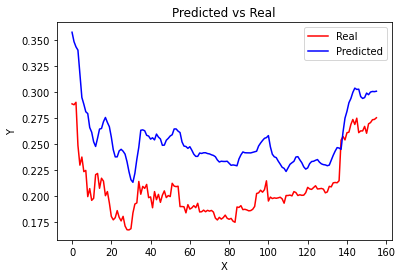

In [16]:
"""
Train the model
"""

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

"""
Plot the training and validation loss
"""

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

"""
Make predictions
"""

predictions = model.predict(X_test)

plt.plot(y_test, color='red', label='Real')
plt.plot(predictions, color='blue', label='Predicted')
plt.title('Predicted vs Real')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## IV - Visualize results 

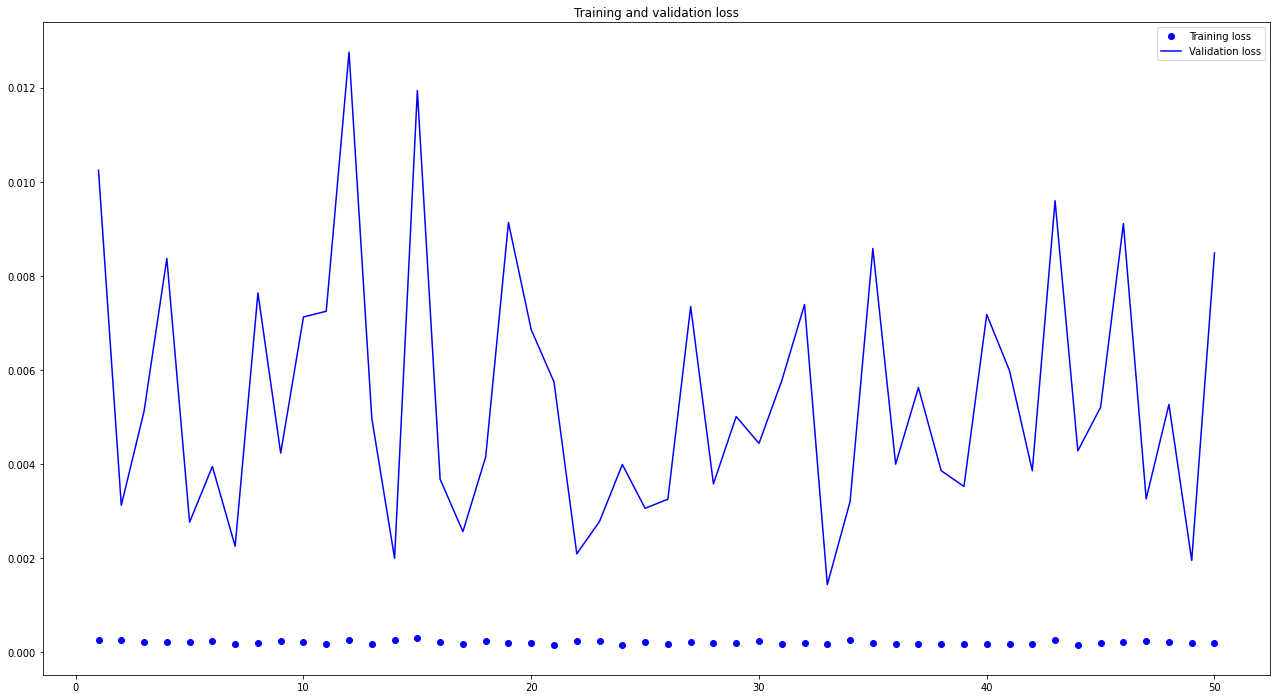

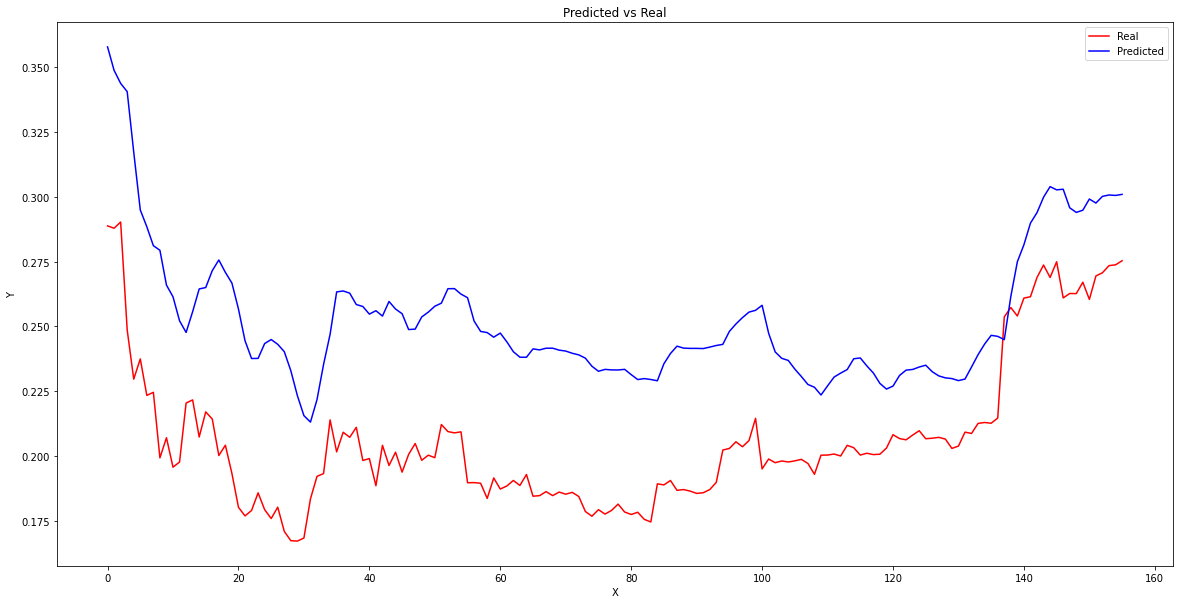

In [19]:
"""
Plot the training and validation loss
"""

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(22,12)) # this line is not written by an AI :)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

"""
Make predictions
"""

predictions = model.predict(X_test)

plt.figure(figsize=(20, 10)) # this line is not written by an AI :)
plt.plot(y_test, color='red', label='Real')
plt.plot(predictions, color='blue', label='Predicted')
plt.title('Predicted vs Real')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [20]:
"""
Save the model
"""

model.save('model.h5')